# <center> ULMIT using wiki103 data and Airline sentment </center>

Cleaning and EDA (graphs) are in three seperate notebooks - Python and R respectively

In [ ]:
#pip install plotnine
#pip install ggplot
#pip3 install git+https://github.com/sushinoya/ggpy

In [250]:
import os
import gc
import psutil
import random
import numpy as np
import pickle
import h5py
import pandas as pd
#from pandas._lib.lib import *
#from pandas.lib import Timestamp
#from ggplot import *
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
import torch
import fastai
from fastai import *
from fastai.text import *
from sklearn.metrics.classification import classification_report
#from fastai.conv_learner import *
fastai.__version__

'1.0.54'

In [ ]:
#psutil.Process(os.getpid()).memory_info().rss

# Preprocessing
Twitter data cleaned in python noteook. Hashtags, emoticons and comevocab removed.

# Reading labeled data to train ULMFiT language model

In [252]:
os.listdir("../input")

['vocabulary-with-stopwords', 'ulmfit-challenge-all-airline-data']

In [253]:
%%time
airline_df = pd.read_csv("../input/ulmfit-challenge-all-airline-data/airline_all_df.csv")
vocab = pd.read_csv("../input/vocabulary-with-stopwords/vocab_stopwords.csv")

CPU times: user 304 ms, sys: 28 ms, total: 332 ms
Wall time: 356 ms


## Create data_lm and clas_lm files from dataframes

In [ ]:
airline_df.columns

In [254]:
#text_df = airline_df[["text_no_punc_num", "sentiment"]]
text_df = airline_df[["text_lowercase_only", "sentiment", "class"]]
train_df, test_df = train_test_split(text_df, \
                                                     test_size = 0.2, \
                                                    random_state = 20190620)
dev_df, test_df = train_test_split(test_df, \
                                                     test_size = 0.5, \
                                                    random_state = 20190620)

sent_data_lm = TextLMDataBunch.from_df(path = "", train_df = train_df, \
                                         valid_df = dev_df, \
                                         bs =32, text_cols = "text_lowercase_only", 
                                       label_cols = "sentiment")

sent_class_lm = TextClasDataBunch.from_df(path = "", train_df = train_df, \
                                         valid_df = dev_df, \
                                         vocab = sent_data_lm.train_ds.vocab, \
                                          text_cols = "text_lowercase_only", 
                                       label_cols = "sentiment",
                                         bs =32)


In [ ]:
type(sent_class_lm)

In [255]:
# Save text data to file
train_df.to_csv("train_df.csv")
dev_df.to_csv("dev_df.csv")
test_df.to_csv("test_df.csv")

#### Download ULMFiT - AWD_LSTM pretrained model

In [256]:
learn_pretrained_model = language_model_learner(sent_data_lm, AWD_LSTM, pretrained = True)

In [257]:
learn_pretrained_model.save("awd_pretrained_model")

In [ ]:
#### Placeholder to load ULMFiT pretrained model

In [258]:
learn_pretrained_model = learn_pretrained_model.load("awd_pretrained_model")

In [ ]:
########################################################################

In [ ]:
#### Search for an optimal learning rate

In [259]:
#%%time

learn_pretrained_model.lr_find(start_lr = slice(1e-10, 1e-5), \
                               end_lr = slice(0.01, 10000))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


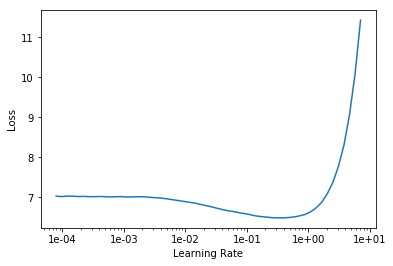

In [260]:
learn_pretrained_model.recorder.plot(suggestions = True)

In [ ]:
#(learn_pretrained_model.recorder.lrs)
Use a learning rate of 1e-2

In [261]:
%%time
random.seed(20190628)
learn_pretrained_model.freeze()
learn_pretrained_model.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.485085,4.840350,0.182478,00:05


CPU times: user 1.62 s, sys: 3.62 s, total: 5.24 s
Wall time: 5.3 s


In [ ]:
Accuracy = 18% using builtin wiki103 weights
Next step unfreeze to update the weights for sentiment data

In [262]:
%%time
#learn_pretrained_model = learn_pretrained_model.load("awd_pretrained_model")
random.seed(20190628)
learn_pretrained_model.unfreeze()
learn_pretrained_model.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.813276,4.504921,0.220945,00:06


CPU times: user 2.12 s, sys: 4.7 s, total: 6.81 s
Wall time: 6.86 s


In [ ]:
Accuracy = 22% using all layers. AWD_LSTM trained on twitter text and predicting "next word(s)" 

In [ ]:
#### Remove last layer

In [263]:
%%time
#learn_pretrained_model.unfreeze()
learn_pretrained_model.freeze_to(-1)
learn_pretrained_model.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.495011,4.450175,0.226302,00:05


CPU times: user 1.76 s, sys: 3.45 s, total: 5.21 s
Wall time: 5.23 s


In [ ]:
Output removed. Accuracy increases remains 22% with output layer removed. 
These LSTMs have a only a 4% improvement in accuracy with twitter text. 
This is perhaps expected given the unique words nad short text found in this domain.

In [264]:
learn_pretrained_model.save_encoder("awd_enc_1")

## Transfer learning - Add new output layer for sentiment classifier.

In [265]:
learn_classifier = text_classifier_learner(sent_class_lm, AWD_LSTM, metrics=accuracy, \
                                           callback_fns=ShowGraph)

In [267]:
#learn_pretrained_model.save_encoder("awd_enc_1")
learn_classifier.load_encoder("awd_enc_1")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


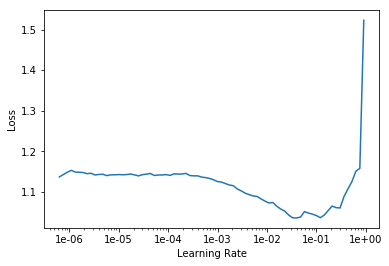

In [268]:
random.seed(20190628)
learn_classifier.lr_find()
learn_classifier.recorder.plot(suggestions = True)

epoch,train_loss,valid_loss,accuracy,time
0,0.752789,0.585082,0.761905,00:04


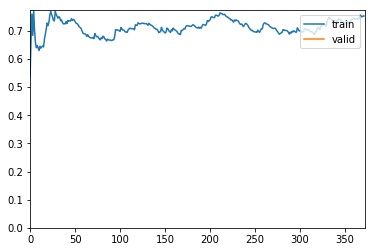

In [270]:
learn_classifier.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.697087,0.570536,0.784038,00:04
1,0.713546,0.548329,0.798122,00:04
2,0.679368,0.563381,0.779343,00:04
3,0.707205,0.572374,0.788732,00:04
4,0.683738,0.565588,0.775989,00:04
5,0.725617,0.561548,0.780684,00:04
6,0.704906,0.551772,0.790074,00:04
7,0.685655,0.547757,0.784708,00:04
8,0.684330,0.550071,0.787391,00:04
9,0.674158,0.554867,0.782696,00:04


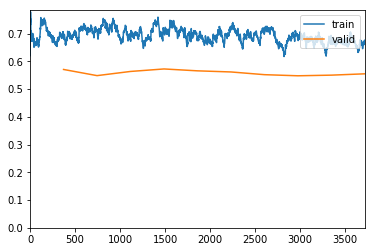

In [271]:
learn_classifier.fit_one_cycle(10, 1e-2)

In [ ]:
When using the 1-cycle policy with epoch = 10, the accuracy remains in the 75%-80%
range, but does a better job on the validation set in terms of losses. 
This proves one cycle does not need long training times to get good results.

In [272]:
learn_classifier.save_encoder("class_awd_enc_1")

In [273]:
learn_classifier.show_results()

text,target,prediction
xxbos i only take jetblue to travel and i have to go to xxunk next year but you guys do nt go to xxunk why do nt you guys go to xxunk,negative,negative
xxbos please xxunk my next flight for me i m waiting on a bus to get me off one plane so i can run to the other it leaves in two min,negative,negative
xxbos i m xxunk to go client b c u ca nt get me there i need refund i filled out form not confident it works if past is an indication,negative,negative
xxbos not happy w app late flightly last time i flew would nt let me check in this time i checked in went on late flightr says i never checked in,negative,negative
xxbos why would you not give us the option to get off the plane instead of sit on it for an hour and a half when you knew at the gate,negative,negative


In [274]:
 interp_classifier = TextClassificationInterpretation.from_learner(learn_classifier)

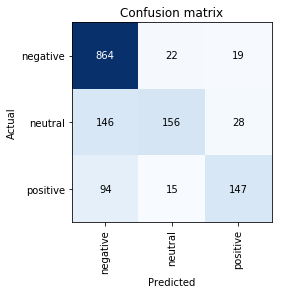

In [275]:
interp_classifier.plot_confusion_matrix()

In [276]:
sent_class_lm.add_test(test_df)
test_preds = learn_classifier.get_preds(DatasetType.Test, ordered = True)
print("Accuracy with output layer removed = ")
test_acc = np.mean(list(test_preds[1]) == test_df["class"]) 
print(round(test_acc*100))
print("Test error = ",  round((1-test_acc)* 100, 1))

Accuracy with output layer removed = 
65.0
Test error =  35.3


In [ ]:
### False Porsitive Rate results on clasification

In [277]:
a = interp_classifier.confusion_matrix()[:,0]
b =(np.sum(interp_classifier.confusion_matrix(), axis = 1))
FPR = 1 - (a/b)
[print(test_df["sentiment"].unique()[i], FPR[i]) for i in range(len(test_df["sentiment"].unique()))]

negative 0.045303867403314935
positive 0.5575757575757576
neutral 0.6328125


[None, None, None]

In [ ]:
On changing the task to sentiment classification the accuracy increases to 75%. 
The pretrained LSTM model + the sentiment classifier does a good job of transfer 
learning with little preprocesing (vocab) and retraining of neural network.

The model can be said to have a variance issue in terms of overfitting as the error increases on the test set.
Techniques for reducing the error (model improvement) are discussed below.

On further drill-down the FPR for negative sentiment is very low. 
The classifier is able to identify neagtive text.Based on the EDA negative sentiment is key in terms 
of the 60% confidence in its classification The model gives 75% on the validation set and 65% on the 
test set overall, but a  vey low FPR = 0.04 on negative sentiment. Hence this appears to be an 
improvement on average on whatever techniqe was used to classify the sentiment. 

The performance on positive and neutral text is low if FPR is considered (0.56 and 0.63). If 
non-negative sentiment is required as part of the applicationn or area of interest then the model needs further tuning.

This is an interesting problem as the overall accuracy is 75% and an overall 
metric can be used that combines accuracy and FPR

Sentiment False Positive Rate (FPR):
Negative = 0.045
Neutral = 0.56
Positive = 0.63

Compare this to 95% accuracy on average achieved  in the ULMFiT original paper and 86% 
achieved by Sandra Faltl et al - https://humboldt-wi.github.io/blog/research/information_systems_1819/group4_ulmfit/
    

In [278]:
%%time
# Export models to files to convert to keras format
# Model weights, optimizer, and parameters
learn_pretrained_model.save("learn_pretrained_model_opt", with_opt = True)
# model weights only
learn_pretrained_model.export("learn_pretrained_model_weights")
# Save pretrained model NN architecture
torch.save(learn_pretrained_model.model, "learn_pretrained_model.pth")

learn_classifier.save("learn_classifier_opt", with_opt = True)
learn_classifier.export("learn_classifier_weights")
# Save classifier NN architecture
torch.save(learn_classifier.model, "learn_classifier.pth")
# Save trained model - above
#learn_classifier.save_encoder("class_awd_enc_1")

CPU times: user 332 ms, sys: 780 ms, total: 1.11 s
Wall time: 1.16 s


In [ ]:
The 75% accuracy could be due to the sentiment, twitter text domain issues, the type of vocab found on
twitter, and/or the classifier.
Note 75% as train-dev accuracy. 65% as test set accuracy. and either do random sample of all 
data for new testset or run code again with leave out sample.

Steps to improve combined model - reduce variance:
    **Tune LSTMs before classifier to see if performance improves on LSTMs**
    Focus on techniques provided. backpropagation, optimization algorithm, L2 (increase lambda) , 
    parameters - Learning rate, epoch, batch size, iterations.
    Smaller set of features = smaller vocab, less nodes (size) etc.

    **Focus on the output layer (sentiment classification) by tuning classifier - NN (neural network), 
    changing NN architecture or using some other classification algorithm such as SVM**.

    **What words are in negative sentiment vs positive and neutral. See what type of words?** 
    Any particular group - by airline, negativereason etc?
    Misclassification of text - what words in certain text does it learn poorly. Modify vocab based 
    on these words learnt. Remove some "twitter" words that have impossibly large no. of characters
    from vocab.                                                   

In [ ]:
**CONCLUSION**
In the airline industry domain the model does a good job of classfying negative sentiment text with a 
False Positive .Rate (FPR) = 0.04
This is inspite of an overall model accuracy = 75% (65% on the test set).
The confidence in the method used for classifying the negative sentiment data is on average = 60-70% 
across airlines - see "EDA_ULMFiT_Airline_sentiment_graphs" notebook. This might be especially useful 
for airlines that have an equal amount of negative, neutral and positive texts, e.g. Southwest and 
Delta where no one sentiment is overly dominant.
This particular model improves the average confidence levels (negativereason_confidence) 
in negative sentiment classification to 93%
